За основу была взята данная статья: https://www.tensorflow.org/tutorials/images/classification

Kaggle Team: Dmitry_Sokolov_16033706

Score: 0.98299

In [ ]:
# Это требуется для использования AdamW
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 8.4MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

In [ ]:
from tensorflow_addons.optimizers import AdamW

In [ ]:
# Load Images from google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q  /content/gdrive/MyDrive/dataset.zip -d /content/
!unzip -q /content/gdrive/MyDrive/testset.zip -d /content/0/ # Для использования image_dataset_from_directory() обязательно нужна подпапка, т.к. иначе не получится загрузить тестовые данные.

In [ ]:
import pathlib
data_dir = pathlib.Path('dataset')
test_dir = pathlib.Path('0')

In [ ]:
# Количество тестовых изображений
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]
len(onlyfiles)

991

In [ ]:
# Количество тренировочных изображений
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20933


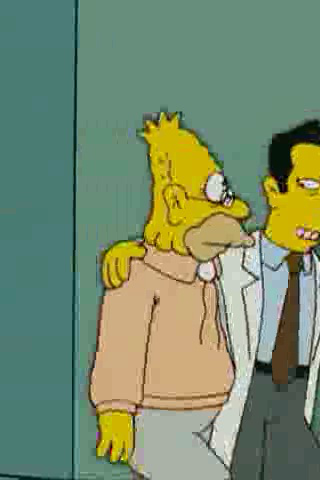

In [ ]:
abraham_grampa_simpson = list(data_dir.glob('abraham_grampa_simpson/*'))
PIL.Image.open(str(abraham_grampa_simpson[0]))

In [ ]:
batch_size = 256
img_height = 128 # Colab при использовании TensofFlow крашится из-за нехватки RAM, если использовать изображения 224*224
img_width = 128

Разбиваем на тренировочную и валидационную выборки

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20933 files belonging to 42 classes.
Using 16747 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20933 files belonging to 42 classes.
Using 4186 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


Изображения для теста:

In [ ]:
number_of_images = len(onlyfiles)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 991 files belonging to 1 classes.


Картинки из трейна:

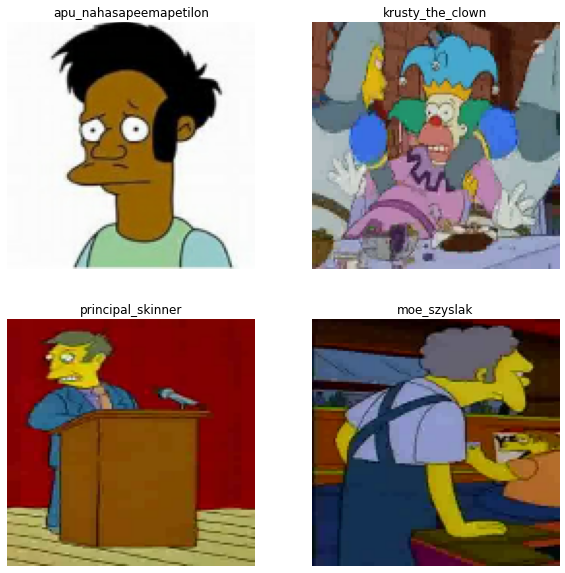

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 128, 128, 3)
(256,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Аугментация

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

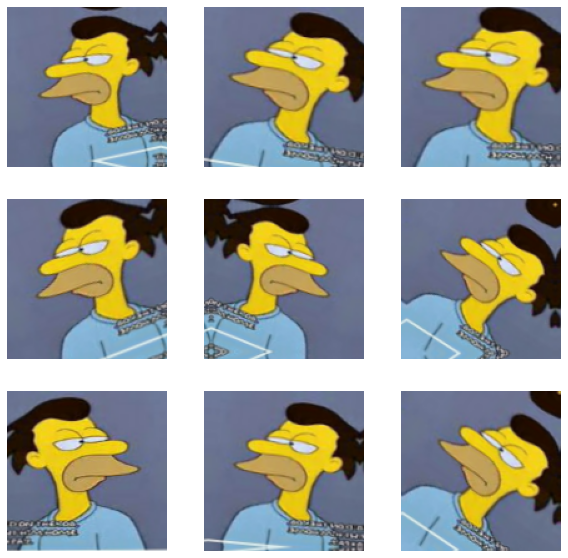

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 42

Модель: 

Добавил BatchNormalization и дополнительный Dropout, поменял оптимайзер на AdamW

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [ ]:
adam_w = AdamW(weight_decay=1e-6)

Добавим F1 метрику (почему-то работает некорректно)

In [ ]:
from tensorflow_addons.metrics import F1Score
f1_score = F1Score(num_classes,average="micro",threshold=0.9)

In [ ]:
model.compile(optimizer=adam_w,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)       

320 эпох и public score: 0.98299, на дальнейшие эксперименты не осталось самбитов на Kaggle :(

Как видно по графику, accuracy все еще имеет тенденцию к росту и если взять больше эпох результат определенно будет выше.

In [ ]:
# checkpoint_path = './checkpoints/simpsons_cnn_tf_cp' # colab не отображает файлы почему-то :(
checkpoint_path = '/content/gdrive/MyDrive/checkpoints/simpsons_cnn_tf_cp'

In [ ]:
# Загружаем сохранненные веса модели (если сохраняли из раньше)
# model.load_weights(checkpoint_path)

In [ ]:
epochs = 320 # 180 is enough for 0.97874 # and after 320 I got 0.98299 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
# проверим точность на валидационной части
# loss, acc = model.evaluate(val_ds, verbose=2)
# print("accuracy: {:5.2f}%".format(100 * acc))

# eval_r = model.evaluate(val_ds, verbose=2)
# print(eval_r)

17/17 - 0s - loss: 0.7568 - accuracy: 0.8894 - f1_score: 0.3263
[0.756755530834198, 0.8893932104110718, 0.32631054520606995]


Сохраняем веса модели, лучше бы это делать в процессе обучения, а не в конце

In [ ]:
model.save_weights(checkpoint_path)
# !ls ./checkpoints/

checkpoint  simpsons_cnn_tf_cp.data-00000-of-00001  simpsons_cnn_tf_cp.index


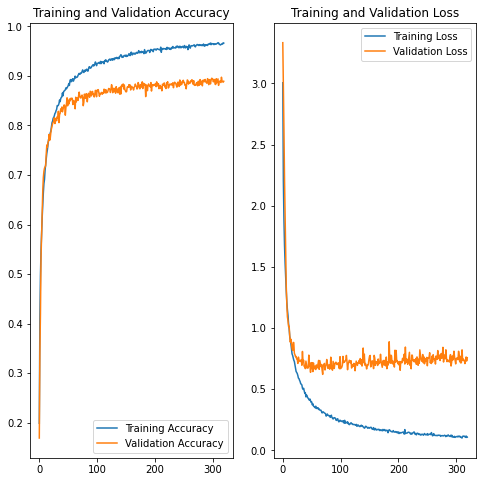

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Предсказание тестовых данных

In [ ]:
image_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

for i in range (batch_size):
  score = tf.nn.softmax(predictions[i])
  print(
    "class: {} with a {:.2f} confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
  
predictions_ = [np.argmax(tf.nn.softmax(i)) for i in predictions]

class: nelson_muntz with a 100.00 confidence.
class: bart_simpson with a 100.00 confidence.
class: ned_flanders with a 100.00 confidence.
class: chief_wiggum with a 100.00 confidence.
class: apu_nahasapeemapetilon with a 100.00 confidence.
class: kent_brockman with a 100.00 confidence.
class: edna_krabappel with a 100.00 confidence.
class: chief_wiggum with a 100.00 confidence.
class: lisa_simpson with a 100.00 confidence.
class: kent_brockman with a 100.00 confidence.
class: lenny_leonard with a 100.00 confidence.
class: marge_simpson with a 100.00 confidence.
class: kent_brockman with a 100.00 confidence.
class: ned_flanders with a 100.00 confidence.
class: moe_szyslak with a 99.63 confidence.
class: comic_book_guy with a 100.00 confidence.
class: abraham_grampa_simpson with a 99.99 confidence.
class: edna_krabappel with a 100.00 confidence.
class: kent_brockman with a 99.75 confidence.
class: lisa_simpson with a 86.20 confidence.
class: marge_simpson with a 100.00 confidence.
class:

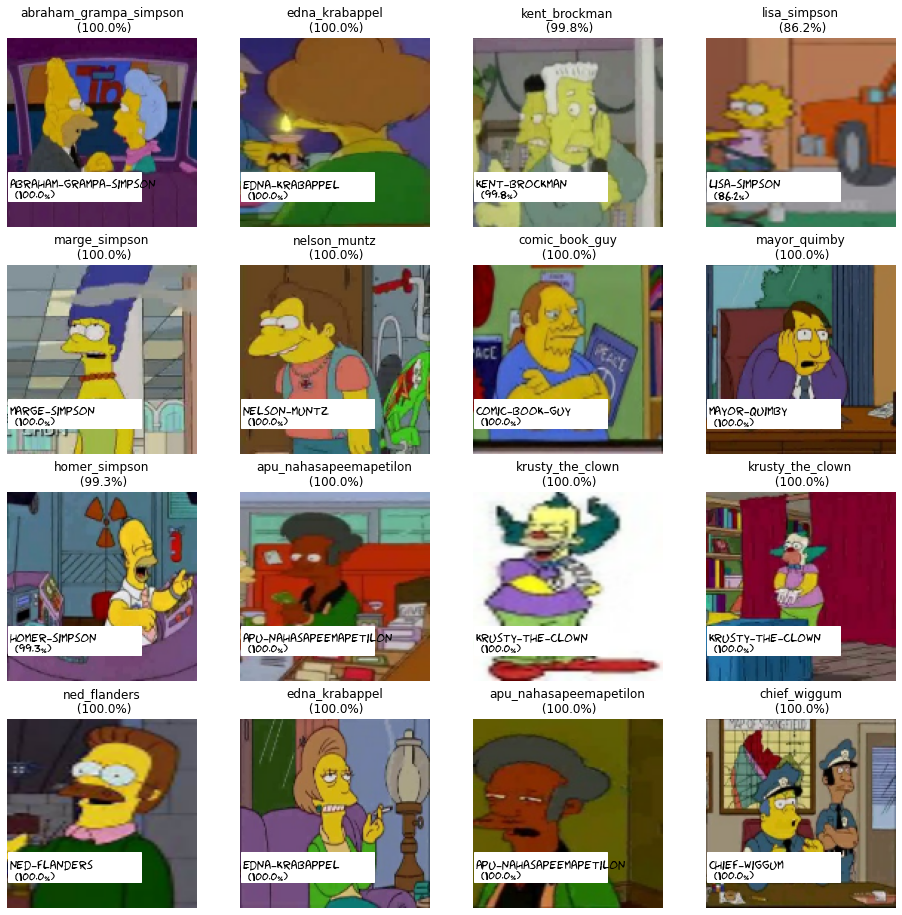

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family("fantasy")

NUMBER_FOR_SHIFT = 16 # Для того, чтобы выбирать разные картинки из батча

plt.figure(figsize=(16, 16))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i+NUMBER_FOR_SHIFT].astype("uint8"))
  conf_str = "{:.1f}".format(100 * np.max(tf.nn.softmax(predictions[i+NUMBER_FOR_SHIFT])))

  ax.add_patch(patches.Rectangle((0, 90),90,20,color='white'))
  ax.text(1, 95,class_names[predictions_[i+NUMBER_FOR_SHIFT]] + '\n ('+ conf_str +'%)', horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=12, color='black',fontweight='bold')

  plt.title(class_names[predictions_[i+NUMBER_FOR_SHIFT]] + '\n ('+ conf_str +'%)')
  plt.axis("off")

In [ ]:
predicted = []
for image_batch in test_ds:
  predicted_batch = model.predict(image_batch)
  predicted_id = np.argmax(predicted_batch, axis=-1)
  predicted_label_batch = []
  for id in predicted_id:
    predicted_label_batch.append(class_names[id])
  predicted.append(predicted_label_batch)

In [ ]:
from pandas.core.common import flatten # список списков в одномерный список
predicted = list(flatten(predicted))

In [ ]:
test_files = sorted(list(test_dir.glob('*/*.jpg'))) # получаем имена файлов тестовых картинок
test_files = [item.name for item in test_files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_f, 'Expected': predicted})
my_submit.to_csv('/content/gdrive/MyDrive/simple_cnn_tf.csv', index=False)
my_submit.to_csv('/content/simple_cnn_tf.csv', index=False)
my_submit.head(5)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
